# Perturbative solver demo

This demo walks through the construction and usage of `PerturbativeSolver` objects for simulating a 2 transmon gate, comparing to traditional solvers using both dense and sparse arrays.

In [1]:
from time import time

import numpy as np

import jax.numpy as jnp
from jax.scipy.linalg import expm as jexpm
from jax.scipy.special import erf
from jax import jit, value_and_grad, vmap


from qiskit.quantum_info import Operator

from qiskit_dynamics import Solver, Signal
from qiskit_dynamics.perturbation import PerturbativeSolver

Configure to use JAX.

In [2]:
from qiskit_dynamics.array import Array

# configure jax to use 64 bit mode
import jax
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update('jax_platform_name', 'cpu')

# set default backend
Array.set_default_backend('jax')

# 1. Define envelope functions

We define a Gaussian square and bipolar Gaussian square pulse shape.

In [3]:
def gaussian_square(t, amp, sigma, risefall, T):
    """Gaussian square pulse."""
    
    t = Array(t).data
    C = jnp.exp(-(2*risefall*sigma)**2/(8*sigma**2))
    den = (jnp.sqrt(jnp.pi*2*sigma**2)*erf(2*risefall*sigma/(jnp.sqrt(8)*sigma))-2*risefall*sigma*C)
    return amp * jnp.piecewise(t,
                         condlist=[t < (risefall * sigma), (T - t) < (risefall * sigma)],
                         funclist=[lambda s: (jnp.exp(-(s-sigma*risefall)**2/(2*sigma**2))-C)/den,
                                   lambda s: (jnp.exp(-(T-s-sigma*risefall)**2/(2*sigma**2))-C)/den,
                                   lambda s: (1-C)/den]
                        )

def bipolar_gaussian_square(t, amp, sigma, risefall, T):
    t = Array(t).data
    unipolar = lambda s: gaussian_square(s, amp, sigma, risefall, T/2)
    return jnp.piecewise(t,
                         condlist=[t < (T/2)],
                         funclist=[unipolar, lambda s: -unipolar(s - T/2)])

Plot an example.

In [4]:
T = 200.
risefall = 2.
sigma = 7.
amp=4.

test = jnp.vectorize(lambda t: bipolar_gaussian_square(t, amp, sigma, risefall, T))

sig = Signal(test)

2022-05-04 11:37:18.190983: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


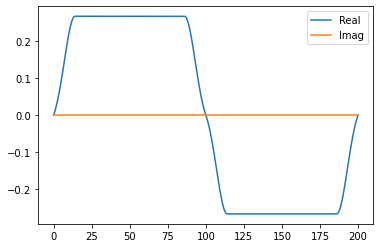

In [5]:
sig.draw(0, T, 1000, function='envelope')

# 2. Construct model operators

We construct a two transmon model:

$$H(t) = 2 \pi \nu a_0 a_0^\dagger + 2 \pi r (a_0 + a_0^\dagger) \\
   + 2 \pi \nu a_1 a_1^\dagger + 2 \pi r (a_1 + a_1^\dagger)\\
   + 2 \pi J (a_0a_1^\dagger + a_0^\dagger a_1)$$

In [6]:
w_c = 2 * np.pi * 5.105
w_t = 2 * np.pi * 5.033
alpha_c = 2 * np.pi * (-0.33516)
alpha_t = 2 * np.pi * (-0.33721)
J = 2 * np.pi * 0.002

dim = 10

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = a.transpose()
N = np.diag(np.arange(dim))
ident = np.eye(dim)
ident2 = np.eye(dim**2)

# operators on the control qubit (first tensor factor)
a0 = np.kron(a, ident)
adag0 = np.kron(adag, ident)
N0 = np.kron(N, ident)

# operators on the target qubit (first tensor factor)
a1 = np.kron(ident, a)
adag1 = np.kron(ident, adag)
N1 = np.kron(ident, N)

In [7]:
H0 = (w_c * N0 + 0.5 * alpha_c * N0 @ (N0 - ident2)
      + w_t * N1 + 0.5 * alpha_t * N1 @ (N1 - ident2)
      + J * (a0 @ adag1 + adag0 @ a1))
Hdc = 2 * np.pi * (a0 + adag0)
Hdt = 2 * np.pi * (a1 + adag1)

## 2.1 Get the dressed computational states qubit frequencies

In [8]:
def basis_vec(ind, dimension):
    vec = np.zeros(dimension, dtype=complex)
    vec[ind] = 1.
    return vec

def two_q_basis_vec(inda, indb, dimension):
    vec_a = basis_vec(inda, dimension)
    vec_b = basis_vec(indb, dimension)
    return np.kron(vec_a, vec_b)

def get_dressed_state_index(inda, indb, dimension, evectors):
    b_vec = two_q_basis_vec(inda, indb, dimension)
    overlaps = np.abs(evectors @ b_vec)
    return overlaps.argmax()

def get_dressed_state_and_energy(inda, indb, dimension, evecs):
    ind = get_dressed_state_index(inda, indb, dimension, evecs)
    return evals[ind], evecs[ind]

Diagonalize and get dressed energies/states for computational states.

In [9]:
evals, B = jnp.linalg.eigh(H0)
Badj = B.conj().transpose()

E00, dressed00 = get_dressed_state_and_energy(0, 0, dim, B.transpose())
E01, dressed01 = get_dressed_state_and_energy(0, 1, dim, B.transpose())
E10, dressed10 = get_dressed_state_and_energy(1, 0, dim, B.transpose())
E11, dressed11 = get_dressed_state_and_energy(1, 1, dim, B.transpose())

# "target dressed frequency"
v_t = E01 / (2 * np.pi)

In [10]:
H0_B = Badj @ H0 @ B
Hdc_B = Badj @ Hdc @ B
Hdt_B = Badj @ Hdt @ B

Define fidelity with respect to the $Z \otimes X$ operator for the computational states.

In [11]:
idx00 = 0
idx01 = get_dressed_state_index(0, 1, dim, B.transpose())
idx10 = get_dressed_state_index(1, 0, dim, B.transpose())
idx11 = get_dressed_state_index(1, 1, dim, B.transpose())

e00 = np.zeros(dim**2, dtype=complex)
e00[0] = 1.
e10 = np.zeros(dim**2, dtype=complex)
e10[idx10] = 1.
e01 = np.zeros(dim**2, dtype=complex)
e01[idx01] = 1.
e11 = np.zeros(dim**2, dtype=complex)
e11[idx11] = 1.

# set up observables
S = np.array([e00, e01, e10, e11]).transpose()
Sdag = S.conj().transpose()

ZX = S @ np.array(Operator.from_label('ZX')) @ Sdag

target = S @ jexpm(-1j * np.array(Operator.from_label('ZX')) * jnp.pi / 4) @ Sdag
target_conj = target.conj()

def fidelity(U):
    return jnp.abs(jnp.sum(target_conj * U))**2 / (4**2)

# 3. Construct dense version of simulation

Here we construct a function for simulating the system in the rotating frame of the drift, using a standard ODE solver, and dense arrays.

In [12]:
dense_solver = Solver(
    static_hamiltonian=H0_B,
    hamiltonian_operators=[Hdc_B, Hdt_B],
    rotating_frame=np.diag(H0_B)
)

y0 = np.eye(dim**2, dtype=complex)

def ode_sim(params, tol):
    cr_amp = params[0]
    rotary_amp = params[1]
    bipolar_amp = params[2] 
    
    cr_phase = params[3]
    rotary_phase = params[4]
    bipolar_phase = params[5]
    
    cr_signal = Signal(lambda t: gaussian_square(t, cr_amp, sigma, risefall, T), 
                       carrier_freq=v_t, 
                       phase=cr_phase)
    rotary_signal = Signal(lambda t: gaussian_square(t, rotary_amp, sigma, risefall, T), 
                           carrier_freq=v_t,
                           phase=rotary_phase)
    bipolar_signal = Signal(lambda t: bipolar_gaussian_square(t, bipolar_amp, sigma, risefall, T), 
                            carrier_freq=v_t,
                            phase=bipolar_phase)
    
    target_signal = (rotary_signal + bipolar_signal).flatten()
    
    solver_copy = dense_solver.copy()
    
    solver_copy.signals = [cr_signal, target_signal]
    results = solver_copy.solve(t_span=[0, T],
                                y0=y0,
                                method='jax_odeint',
                                atol=tol,
                                rtol=tol)
    return results.y[-1]


def ode_obj(params, tol):
    return fidelity(ode_sim(params, tol))


## Setup a collection of inputs values and create benchmark final unitaries

In [33]:
num_inputs=4
input_params = jnp.array(np.random.uniform(low=-2, high=2, size=(num_inputs, 6)))

# orig = jnp.array([1.4, 1., 0.3, 0., 0., 0.])

In [34]:
jnp.array([input_params[0]])

DeviceArray([[-1.28648093, -0.39053822,  1.35252538, -1.50415701,
              -0.40970719, -1.76772651]], dtype=float64)

In [35]:
# loop over and run simulations
sim_func = jit(lambda x: ode_sim(x, 1e-10))
vmap_sim_func = jit(vmap(sim_func))
# vmap_sim_func = vmap(sim_func)
start = time()
vmap_sim_func(jnp.array([input_params[0]])).block_until_ready()
vmap_jit_time = time() - start

In [36]:
benchmark_sim = jit(lambda x: ode_sim(x, 1e-14))

benchmark_yfs = [benchmark_sim(x) for x in input_params]

## Create error metrics and function for running sims

In [37]:
def distance(U, V):
    return jnp.linalg.norm(U - V) / dim


target = S @ jexpm(-1j * np.array(Operator.from_label('ZX')) * jnp.pi / 4) @ Sdag
target_conj = target.conj()

def gate_fidelity(U):
    return jnp.abs(jnp.sum(target_conj * U))**2 / (4**2)

In [45]:
from time import time

def compute_solver_metrics(sim_func):
    sim_func = jit(sim_func)
    
    # time to jit
    start = time()
    sim_func(input_params[0]).block_until_ready()
    jit_time = time() - start
    
    # loop over and run simulations
    start = time()
    vmap_func = jit(vmap(sim_func))
    yfs = vmap_func(input_params)
#     for i in range(num_inputs)[::2]:
#         short_input=jnp.array([input_params[i], input_params[i+1]])
#         yfs = vmap_sim_func(short_input).block_until_ready()
#     yfs = [sim_func(x) for x in input_params]
    ave_run_time = (time() - start) / len(input_params)
    
    distances = []
    for yf, benchmark_yf in zip(yfs, benchmark_yfs):
        distances.append(distance(yf, benchmark_yf))
    
    ave_distance = np.sum(distances).real / len(input_params)
    
    def fid_func(x):
        yf = sim_func(x)
        return gate_fidelity(yf)

    jit_grad_fid_func = jit(value_and_grad(fid_func))
    
    # time to jit
    start = time()
    jit_grad_fid_func(input_params[0])[0].block_until_ready()
    jit_grad_time = time() - start
    
    # time to compute gradients
    start = time()
    for x in input_params:
        jit_grad_fid_func(x)[0].block_until_ready()
    ave_grad_run_time = (time() - start) / len(input_params)
    
    return {
        'jit_time': jit_time,
        'ave_run_time': ave_run_time,
        'ave_distance': ave_distance,
        'jit_grad_time': jit_grad_time,
        'ave_grad_run_time': ave_grad_run_time
    }

# Dense simulation

Run the sims for dense simulation at various tolerances.

we should run this for up to `k==1e-13`, and possibly even for intermediate values to fill out the curve.

In [ ]:
tols = [10**-k for k in range(6, 9)]

dense_results = []
for tol in tols:
    dense_results.append(compute_solver_metrics(lambda params: ode_sim(params, tol)))

In [41]:
dense_results

[{'jit_time': 13.113801002502441,
  'ave_run_time': 95.74349546432495,
  'ave_distance': 0.6772811092285915,
  'jit_grad_time': 90.11631798744202,
  'ave_grad_run_time': 87.9086201786995},
 {'jit_time': 19.012102603912354,
  'ave_run_time': 97.42010116577148,
  'ave_distance': 0.6772811092285915,
  'jit_grad_time': 150.7567527294159,
  'ave_grad_run_time': 146.86474603414536}]

# Sparse version of simulation

For sparse simulation we need to make sure we are in a basis in which the operators are actually sparse.

In [20]:
sparse_solver = Solver(
    static_hamiltonian=H0,
    hamiltonian_operators=[Hdc, Hdt],
    rotating_frame=np.diag(H0),
    evaluation_mode='sparse'
)

y0_sparse = B @ y0

def ode_sparse_sim(params, tol):
    cr_amp = params[0]
    rotary_amp = params[1]
    bipolar_amp = params[2] 
    
    cr_phase = params[3]
    rotary_phase = params[4]
    bipolar_phase = params[5]
    
    cr_signal = Signal(lambda t: gaussian_square(t, cr_amp, sigma, risefall, T), 
                       carrier_freq=v_t, 
                       phase=cr_phase)
    rotary_signal = Signal(lambda t: gaussian_square(t, rotary_amp, sigma, risefall, T), 
                           carrier_freq=v_t,
                           phase=rotary_phase)
    bipolar_signal = Signal(lambda t: bipolar_gaussian_square(t, bipolar_amp, sigma, risefall, T), 
                            carrier_freq=v_t,
                            phase=bipolar_phase)
    
    target_signal = (rotary_signal + bipolar_signal).flatten()
    
    solver_copy = sparse_solver.copy()
    
    solver_copy.signals = [cr_signal, target_signal]
    results = solver_copy.solve(t_span=[0, T],
                                y0=y0_sparse,
                                method='jax_odeint',
                                atol=tol,
                                rtol=tol)
    
    # transfer unitary into same basis and frame as the dense simulation
    U = Array(Badj) @ solver_copy.model.rotating_frame.state_out_of_frame(T, results.y[-1])
    U = dense_solver.model.rotating_frame.state_into_frame(T, U).data
    
    return U

In [ ]:
sparse_results = []
for tol in tols:
    sparse_results.append(compute_solver_metrics(lambda params: ode_sparse_sim(params, tol)))

# Dyson solver

In [46]:
# system information
operators = [-1j  * Hdc_B, -1j * Hdt_B]
carrier_freqs = [v_t, v_t]
frame_operator = -1j * np.diag(H0_B)

def perturbative_solver_metrics(
    n_steps, 
    expansion_order, 
    chebyshev_order, 
    expansion_method='dyson'
):
    dt = T / n_steps
    
    # construct solver
    start = time()
    perturb_solver = PerturbativeSolver(
        operators=operators,
        rotating_frame=frame_operator,
        dt=dt,
        carrier_freqs=carrier_freqs,
        chebyshev_orders=[chebyshev_order] * 2,
        expansion_method=expansion_method,
        expansion_order=expansion_order,
        integration_method='jax_odeint',
        atol=1e-13,
        rtol=1e-13
    )
    construction_time = time() - start
    
    def perturb_sim(params):
        cr_amp = params[0]
        rotary_amp = params[1]
        bipolar_amp = params[2] 

        cr_phase = params[3]
        rotary_phase = params[4]
        bipolar_phase = params[5]

        cr_signal = Signal(lambda t: gaussian_square(t, cr_amp, sigma, risefall, T), 
                           carrier_freq=v_t, 
                           phase=cr_phase)
        rotary_signal = Signal(lambda t: gaussian_square(t, rotary_amp, sigma, risefall, T), 
                               carrier_freq=v_t,
                               phase=rotary_phase)
        bipolar_signal = Signal(lambda t: bipolar_gaussian_square(t, bipolar_amp, sigma, risefall, T), 
                                carrier_freq=v_t,
                                phase=bipolar_phase)

        target_signal = (rotary_signal + bipolar_signal).flatten()

        return perturb_solver.solve([cr_signal, target_signal], y0, 0., n_steps)

    results = compute_solver_metrics(perturb_sim)
    results['construction_time'] = construction_time
    return results


For reference, this is a value that gives a very high quality approximation. 

In [47]:
test = perturbative_solver_metrics(
    n_steps=30000,
    expansion_order=4,
    chebyshev_order=2,
)

TracerIntegerConversionError: The __index__() method was called on the JAX Tracer object Traced<ShapedArray(int64[], weak_type=True)>with<DynamicJaxprTrace(level=3/0)>
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerIntegerConversionError

In [24]:
dense_results

[{'jit_time': 12.714799880981445,
  'ave_run_time': 14.636967023213705,
  'ave_distance': 0.009430727694487107,
  'jit_grad_time': 107.71017074584961,
  'ave_grad_run_time': 99.54617675145467},
 {'jit_time': 23.126384258270264,
  'ave_run_time': 23.955566962560017,
  'ave_distance': 0.0005893526275394577,
  'jit_grad_time': 170.26764297485352,
  'ave_grad_run_time': 151.2617483139038},
 {'jit_time': 26.907774209976196,
  'ave_run_time': 28.528197367986042,
  'ave_distance': 2.6659912330509012e-05,
  'jit_grad_time': 263.61266040802,
  'ave_grad_run_time': 271.91982261339825}]

In [25]:
tes

<function __main__.<lambda>(t)>

We should generate data for perturbative solvers, for both Dyson and Magnus, treating `n_steps` analogously to `tol` for the usual solvers. I.e. for different expansion orders and chebyshev orders, generate the metrics for a range of `n_steps`. We'll need to play around to see what actual values of `n_steps` to explore (e.g. cranking it really high to get as high a tolerance as possible).

For CPU, can we pin this to a single core?

In [ ]:
test"{'jit_time': 8.807554960250854,
 'ave_run_time': 1.5672102689743042,
 'ave_distance': 2.4076992260531547e-08,
 'jit_grad_time': 23.593711853027344,
 'ave_grad_run_time': 4.455309414863587,
 'construction_time': 31.25236678123474}"

In [ ]:
dense_results"[{'jit_time': 2.934943437576294,
  'ave_run_time': 0.7882565021514892,
  'ave_distance': 0.0038056807265508313,
  'jit_grad_time': 12.229278802871704,
  'ave_grad_run_time': 4.830108022689819},
 {'jit_time': 3.497884511947632,
  'ave_run_time': 1.2448240518569946,
  'ave_distance': 0.00019116220058663745,
  'jit_grad_time': 14.589717149734497,
  'ave_grad_run_time': 7.7859468221664425},
 {'jit_time': 3.8204681873321533,
  'ave_run_time': 1.779462170600891,
  'ave_distance': 9.305160510893629e-06,
  'jit_grad_time': 18.232216835021973,
  'ave_grad_run_time': 10.996834254264831}]"

In [ ]:
sparse_results"[{'jit_time': 2.9687247276306152,
  'ave_run_time': 0.6569108963012695,
  'ave_distance': 0.0038262962281479275,
  'jit_grad_time': 12.376525402069092,
  'ave_grad_run_time': 4.482078433036804},
 {'jit_time': 3.538027286529541,
  'ave_run_time': 1.050394058227539,
  'ave_distance': 0.00018769907057950274,
  'jit_grad_time': 15.0888032913208,
  'ave_grad_run_time': 7.085251450538635},
 {'jit_time': 4.06965708732605,
  'ave_run_time': 1.6412882804870605,
  'ave_distance': 9.034796610994981e-06,
  'jit_grad_time': 19.52087378501892,
  'ave_grad_run_time': 10.986740112304688}]"

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(dense_results)
df['tol'] = tols

In [ ]:
df